In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import datetime, os

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [7]:
dataset = './data/audi_train.tfrecord' #'path to dataset'
val_dataset = './data/audi_val.tfrecord' # 'path to validation dataset'
weights = './checkpoints/yolov3.tf' #'path to weights file'
classes = './data/classes.txt' #'path to classes file'
mode = 'fit' #['fit', 'eager_fit', 'eager_tf']
             #'fit: model.fit, '
             #'eager_fit: model.fit(run_eagerly=True), '
             #'eager_tf: custom GradientTape'
transfer = 'darknet'
             #['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
             #'none: Training from scratch, '
             #'darknet: Transfer darknet, '
             #'no_output: Transfer all but output, '
             #'frozen: Transfer and freeze all, '
             #'fine_tune: Transfer all and freeze darknet only'
size = 416 #'image size'
epochs = 100 #'number of epochs'
batch_size = 64 #'batch size'
learning_rate = 0.01 #'learning rate'
num_classes = 14 #'number of classes in the model'
weights_num_classes = 80 #'specify num class for `weights` file if different, '
                         #'useful in transfer learning with different number of classes'


def train_model():  
    model = YoloV3(size, training=True, classes=num_classes)
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    train_dataset = load_fake_dataset()
    if dataset:
        train_dataset = load_tfrecord_dataset(dataset, classes, size)
    train_dataset = train_dataset.shuffle(buffer_size=512)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.map(lambda x, y: (
        transform_images(x, size),
        transform_targets(y, anchors, anchor_masks, size)))
    train_dataset = train_dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)
    
    v_dataset = load_fake_dataset()
    if val_dataset:
        v_dataset = load_tfrecord_dataset(val_dataset, classes, size)
    v_dataset = v_dataset.batch(batch_size)
    v_dataset = v_dataset.map(lambda x, y: (
        transform_images(x, size),
        transform_targets(y, anchors, anchor_masks, size)))
    
    # Configure the model for transfer learning
    if transfer == 'none':
        pass  # Nothing to do
    elif transfer in ['darknet', 'no_output']:
        # Darknet transfer is a special case that works
        # with incompatible number of classes

        # reset top layers
        model_pretrained = YoloV3(
            size, training=True, classes=weights_num_classes or num_classes)
        model_pretrained.load_weights(weights)

        if transfer == 'darknet':
            model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
            freeze_all(model.get_layer('yolo_darknet'))

        elif transfer == 'no_output':
            for l in model.layers:
                if not l.name.startswith('yolo_output'):
                    l.set_weights(model_pretrained.get_layer(
                        l.name).get_weights())
                    freeze_all(l)

    else:
        # All other transfer require matching classes
        model.load_weights(weights)
        if transfer == 'fine_tune':
            # freeze darknet and fine tune other layers
            darknet = model.get_layer('yolo_darknet')
            freeze_all(darknet)
        elif transfer == 'frozen':
            # freeze everything
            freeze_all(model)

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=num_classes)
            for mask in anchor_masks]

    if mode == 'eager_tf':
        # Eager mode is great for debugging
        # Non eager graph mode is recommended for real training
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

        for epoch in range(1, epochs + 1):
            for batch, (images, labels) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    outputs = model(images, training=True)
                    regularization_loss = tf.reduce_sum(model.losses)
                    pred_loss = []
                    for output, label, loss_fn in zip(outputs, labels, loss):
                        pred_loss.append(loss_fn(label, output))
                    total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                grads = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(
                    zip(grads, model.trainable_variables))

                logging.info("{}_train_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_loss.update_state(total_loss)

            for batch, (images, labels) in enumerate(v_dataset):
                outputs = model(images)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                logging.info("{}_val_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_val_loss.update_state(total_loss)

            logging.info("{}, train: {}, val: {}".format(
                epoch,
                avg_loss.result().numpy(),
                avg_val_loss.result().numpy()))

            avg_loss.reset_states()
            avg_val_loss.reset_states()
            model.save_weights(
                'checkpoints/yolov3_train_{}.tf'.format(epoch))
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'],
                      run_eagerly=(mode == 'eager_fit'))

        callbacks = [
            ReduceLROnPlateau(monitor='loss',verbose=1),
            EarlyStopping(patience=3,monitor='loss', verbose=1),
            ModelCheckpoint('checkpoints/yolov3_train_{epoch}.tf',
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

        history = model.fit(train_dataset,
                            epochs=epochs,
                            callbacks=callbacks,
                            validation_data=v_dataset)
    return model

In [5]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 1994), started 0:10:05 ago. (Use '!kill 1994' to kill it.)

In [6]:
train_model()

Epoch 1/50
    515/Unknown - 7070s 14s/step - loss: 238.1716 - yolo_output_0_loss: 12.3531 - yolo_output_1_loss: 41.7612 - yolo_output_2_loss: 173.0352
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
515/515 [==============================] - 8315s 16s/step - loss: 238.1722 - yolo_output_0_loss: 12.3531 - yolo_output_1_loss: 41.7612 - yolo_output_2_loss: 173.0352 - val_loss: 33.2720 - val_yolo_output_0_loss: 1.9814 - val_yolo_output_1_loss: 6.9337 - val_yolo_output_2_loss: 13.3413
Epoch 2/50
514/515 [============================>.] - ETA: 13s - loss: 26.3463 - yolo_output_0_loss: 1.4225 - yolo_output_1_loss: 5.8036 - yolo_output_2_loss: 8.1304
Epoch 00002: saving model to checkpoints/yolov3_train_2.tf
515/515 [==============================] - 8288s 16s/step - loss: 26.3359 - yolo_output_0_loss: 1.4247 - yolo_output_1_loss: 5.8019 - yolo_output_2_loss: 8.1195 - val_loss: 23.4288 - val_yolo_output_0_loss: 1.4330 - val_yolo_output_1_loss: 5.3432 - val_yolo_output_2_loss: 5.692

514/515 [============================>.] - ETA: 14s - loss: 11.9322 - yolo_output_0_loss: 0.3526 - yolo_output_1_loss: 0.8577 - yolo_output_2_loss: 0.5530
Epoch 00033: saving model to checkpoints/yolov3_train_33.tf
515/515 [==============================] - 8596s 17s/step - loss: 11.9402 - yolo_output_0_loss: 0.3549 - yolo_output_1_loss: 0.8644 - yolo_output_2_loss: 0.5519 - val_loss: 24.9124 - val_yolo_output_0_loss: 1.4656 - val_yolo_output_1_loss: 7.4379 - val_yolo_output_2_loss: 5.8525
Epoch 34/50
514/515 [============================>.] - ETA: 13s - loss: 11.9633 - yolo_output_0_loss: 0.3438 - yolo_output_1_loss: 0.8991 - yolo_output_2_loss: 0.5558
Epoch 00034: saving model to checkpoints/yolov3_train_34.tf
515/515 [==============================] - 8158s 16s/step - loss: 11.9604 - yolo_output_0_loss: 0.3433 - yolo_output_1_loss: 0.8979 - yolo_output_2_loss: 0.5547 - val_loss: 24.6326 - val_yolo_output_0_loss: 1.4358 - val_yolo_output_1_loss: 7.6299 - val_yolo_output_2_loss: 5.447

In [7]:
h = train_model()

Epoch 1/50
     65/Unknown - 9968s 153s/step - loss: 1096.2535 - yolo_output_0_loss: 71.0202 - yolo_output_1_loss: 182.6927 - yolo_output_2_loss: 831.6105 - yolo_output_0_accuracy: 0.0036 - yolo_output_1_accuracy: 0.0099 - yolo_output_2_accuracy: 0.0399
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
65/65 [==============================] - 11526s 177s/step - loss: 1096.4164 - yolo_output_0_loss: 71.0202 - yolo_output_1_loss: 182.6927 - yolo_output_2_loss: 831.6105 - yolo_output_0_accuracy: 0.0036 - yolo_output_1_accuracy: 0.0099 - yolo_output_2_accuracy: 0.0399 - val_loss: 950.4344 - val_yolo_output_0_loss: 33.6139 - val_yolo_output_1_loss: 65.5902 - val_yolo_output_2_loss: 840.2179 - val_yolo_output_0_accuracy: 0.0052 - val_yolo_output_1_accuracy: 2.3763e-04 - val_yolo_output_2_accuracy: 0.0974
Epoch 2/50
64/65 [============================>.] - ETA: 2:03 - loss: 105.1743 - yolo_output_0_loss: 3.8767 - yolo_output_1_loss: 15.2487 - yolo_output_2_loss: 75.0367 - yolo_output

64/65 [============================>.] - ETA: 2:11 - loss: 23.1648 - yolo_output_0_loss: 0.9392 - yolo_output_1_loss: 4.1345 - yolo_output_2_loss: 7.1559 - yolo_output_0_accuracy: 0.0528 - yolo_output_1_accuracy: 0.1019 - yolo_output_2_accuracy: 0.0447
Epoch 00011: saving model to checkpoints/yolov3_train_11.tf
65/65 [==============================] - 9796s 151s/step - loss: 23.1168 - yolo_output_0_loss: 0.9393 - yolo_output_1_loss: 4.1111 - yolo_output_2_loss: 7.1307 - yolo_output_0_accuracy: 0.0527 - yolo_output_1_accuracy: 0.1019 - yolo_output_2_accuracy: 0.0450 - val_loss: 25.0649 - val_yolo_output_0_loss: 1.5838 - val_yolo_output_1_loss: 5.3711 - val_yolo_output_2_loss: 7.1803 - val_yolo_output_0_accuracy: 0.0181 - val_yolo_output_1_accuracy: 0.1420 - val_yolo_output_2_accuracy: 0.1169
Epoch 12/50
64/65 [============================>.] - ETA: 2:11 - loss: 22.0610 - yolo_output_0_loss: 0.8443 - yolo_output_1_loss: 3.8080 - yolo_output_2_loss: 6.4848 - yolo_output_0_accuracy: 0.0751

64/65 [============================>.] - ETA: 2:16 - loss: 12.5174 - yolo_output_0_loss: 0.2227 - yolo_output_1_loss: 0.5207 - yolo_output_2_loss: 1.1314 - yolo_output_0_accuracy: 0.1170 - yolo_output_1_accuracy: 0.0821 - yolo_output_2_accuracy: 0.1237
Epoch 00031: saving model to checkpoints/yolov3_train_31.tf
65/65 [==============================] - 10156s 156s/step - loss: 12.5119 - yolo_output_0_loss: 0.2211 - yolo_output_1_loss: 0.5187 - yolo_output_2_loss: 1.1296 - yolo_output_0_accuracy: 0.1168 - yolo_output_1_accuracy: 0.0820 - yolo_output_2_accuracy: 0.1236 - val_loss: 22.9300 - val_yolo_output_0_loss: 1.2524 - val_yolo_output_1_loss: 6.3934 - val_yolo_output_2_loss: 4.6532 - val_yolo_output_0_accuracy: 0.0603 - val_yolo_output_1_accuracy: 0.0569 - val_yolo_output_2_accuracy: 0.1234
Epoch 32/50
64/65 [============================>.] - ETA: 2:20 - loss: 12.4697 - yolo_output_0_loss: 0.2177 - yolo_output_1_loss: 0.5345 - yolo_output_2_loss: 1.0967 - yolo_output_0_accuracy: 0.120

KeyboardInterrupt: 

In [ ]:
m = train_model()

Epoch 1/60
    129/Unknown - 7219s 56s/step - loss: 814.8917 - yolo_output_0_loss: 32.2317 - yolo_output_1_loss: 115.1710 - yolo_output_2_loss: 656.5025 - yolo_output_0_accuracy: 0.0316 - yolo_output_1_accuracy: 0.0322 - yolo_output_2_accuracy: 0.0947
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
129/129 [==============================] - 8427s 65s/step - loss: 814.9110 - yolo_output_0_loss: 32.2317 - yolo_output_1_loss: 115.1710 - yolo_output_2_loss: 656.5025 - yolo_output_0_accuracy: 0.0316 - yolo_output_1_accuracy: 0.0322 - yolo_output_2_accuracy: 0.0947 - val_loss: 246.7196 - val_yolo_output_0_loss: 11.7320 - val_yolo_output_1_loss: 45.3045 - val_yolo_output_2_loss: 178.6517 - val_yolo_output_0_accuracy: 0.1234 - val_yolo_output_1_accuracy: 8.2281e-04 - val_yolo_output_2_accuracy: 0.0302
Epoch 2/60
128/129 [============================>.] - ETA: 55s - loss: 70.7219 - yolo_output_0_loss: 2.5831 - yolo_output_1_loss: 11.6062 - yolo_output_2_loss: 45.5045 - yolo_output_0_

In [ ]:
tm = train_model()

Epoch 1/100
    129/Unknown - 7174s 56s/step - loss: 307.9240 - yolo_output_0_loss: 20.7635 - yolo_output_1_loss: 76.3762 - yolo_output_2_loss: 168.8605 - yolo_output_0_accuracy: 0.0143 - yolo_output_1_accuracy: 0.0014 - yolo_output_2_accuracy: 0.0022
Epoch 00001: saving model to checkpoints/yolov3_train_1.tf
129/129 [==============================] - 8374s 65s/step - loss: 307.9304 - yolo_output_0_loss: 20.7635 - yolo_output_1_loss: 76.3762 - yolo_output_2_loss: 168.8605 - yolo_output_0_accuracy: 0.0143 - yolo_output_1_accuracy: 0.0014 - yolo_output_2_accuracy: 0.0022 - val_loss: 159.7894 - val_yolo_output_0_loss: 18.6751 - val_yolo_output_1_loss: 53.4657 - val_yolo_output_2_loss: 43.3604 - val_yolo_output_0_accuracy: 0.0024 - val_yolo_output_1_accuracy: 0.0022 - val_yolo_output_2_accuracy: 3.7386e-05
Epoch 2/100
128/129 [============================>.] - ETA: 55s - loss: 59.7014 - yolo_output_0_loss: 2.8061 - yolo_output_1_loss: 8.4885 - yolo_output_2_loss: 6.2061 - yolo_output_0_acc

128/129 [============================>.] - ETA: 56s - loss: 27.8501 - yolo_output_0_loss: 1.1285 - yolo_output_1_loss: 3.9230 - yolo_output_2_loss: 3.2741 - yolo_output_0_accuracy: 0.0712 - yolo_output_1_accuracy: 0.0225 - yolo_output_2_accuracy: 0.0232 
Epoch 00011: saving model to checkpoints/yolov3_train_11.tf
129/129 [==============================] - 8531s 66s/step - loss: 27.8461 - yolo_output_0_loss: 1.1341 - yolo_output_1_loss: 3.9222 - yolo_output_2_loss: 3.2698 - yolo_output_0_accuracy: 0.0718 - yolo_output_1_accuracy: 0.0225 - yolo_output_2_accuracy: 0.0231 - val_loss: 29.3645 - val_yolo_output_0_loss: 1.5632 - val_yolo_output_1_loss: 5.1039 - val_yolo_output_2_loss: 3.7670 - val_yolo_output_0_accuracy: 0.2523 - val_yolo_output_1_accuracy: 0.0107 - val_yolo_output_2_accuracy: 0.0030
Epoch 12/100
128/129 [============================>.] - ETA: 56s - loss: 26.4406 - yolo_output_0_loss: 1.0608 - yolo_output_1_loss: 3.7792 - yolo_output_2_loss: 3.1868 - yolo_output_0_accuracy: 0

128/129 [============================>.] - ETA: 59s - loss: 17.2493 - yolo_output_0_loss: 0.8654 - yolo_output_1_loss: 2.4912 - yolo_output_2_loss: 1.7709 - yolo_output_0_accuracy: 0.1265 - yolo_output_1_accuracy: 0.0382 - yolo_output_2_accuracy: 0.0223 
Epoch 00031: saving model to checkpoints/yolov3_train_31.tf
129/129 [==============================] - 8854s 69s/step - loss: 17.2495 - yolo_output_0_loss: 0.8672 - yolo_output_1_loss: 2.4911 - yolo_output_2_loss: 1.7696 - yolo_output_0_accuracy: 0.1269 - yolo_output_1_accuracy: 0.0381 - yolo_output_2_accuracy: 0.0225 - val_loss: 23.9072 - val_yolo_output_0_loss: 1.3806 - val_yolo_output_1_loss: 5.9400 - val_yolo_output_2_loss: 4.5018 - val_yolo_output_0_accuracy: 0.2335 - val_yolo_output_1_accuracy: 0.0187 - val_yolo_output_2_accuracy: 0.0695
Epoch 32/100
128/129 [============================>.] - ETA: 58s - loss: 17.2027 - yolo_output_0_loss: 0.8228 - yolo_output_1_loss: 2.5479 - yolo_output_2_loss: 1.7573 - yolo_output_0_accuracy: 0

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
lossDf = pd.read_csv('./data/YOLO_Loss.csv')
lossDf.head()

,epoch,loss,yolo_output_0_loss,yolo_output_1_loss,yolo_output_2_loss,val_loss,val_yolo_output_0_loss,val_yolo_output_1_loss,val_yolo_output_2_loss
0,1,238.1722,12.3531,41.7612,173.0352,33.2720,1.9814,6.9337,13.3413
1,2,26.3359,1.4247,5.8019,8.1195,23.4288,1.4330,5.3432,5.6927
2,3,21.7387,1.1585,4.6940,4.9596,21.6229,1.1794,5.0383,4.5144
3,4,19.7819,0.9793,4.0094,3.9408,20.4556,1.1671,4.6268,3.8507
4,5,18.5161,0.8645,3.5368,3.3441,20.3497,1.2065,4.9364,3.4781


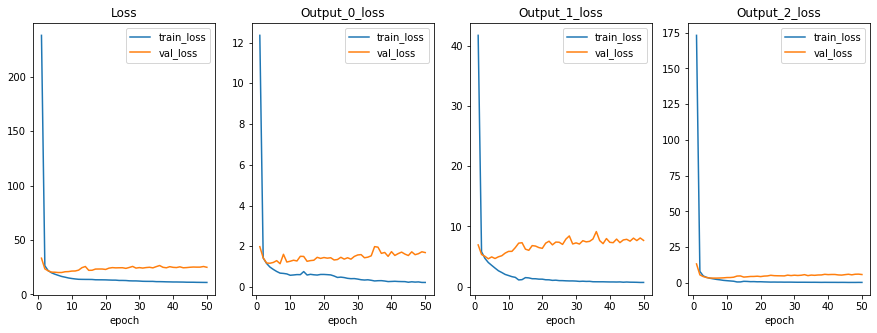

In [41]:
x = lossDf.epoch
fig, ax = plt.subplots(nrows=1,ncols = 4,figsize=(15,5))
l1,l2 = ax[0].plot(x, lossDf[['loss','val_loss']])
_ = ax[0].set_xlabel('epoch')
_ = ax[0].set_title('Loss')
_ = ax[0].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[1].plot(x, lossDf[['yolo_output_0_loss','val_yolo_output_0_loss']])
_ = ax[1].set_xlabel('epoch')
_ = ax[1].set_title('Output_0_loss')
_ = ax[1].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[2].plot(x, lossDf[['yolo_output_1_loss','val_yolo_output_1_loss']])
_ = ax[2].set_xlabel('epoch')
_ = ax[2].set_title('Output_1_loss')
_ = ax[2].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[3].plot(x, lossDf[['yolo_output_2_loss','val_yolo_output_2_loss']])
_ = ax[3].set_xlabel('epoch')
_ = ax[3].set_title('Output_2_loss')
_ = ax[3].legend([l1,l2],['train_loss','val_loss'])

In [15]:
lossDf = pd.read_csv('./data/YOLO_Loss_Train2.csv')
lossDf.head()

,Epoch,loss,yolo_output_0_loss,yolo_output_1_loss,yolo_output_2_loss,val_loss,val_yolo_output_0_loss,val_yolo_output_1_loss,val_yolo_output_2_loss
0,1,708.7898,56.5260,150.9620,462.2278,6.225579e+06,146.8774,862541.3750,5.362844e+06
1,2,69.6816,4.5952,11.8576,7.6477,1.549065e+02,16.2746,68.1177,2.611000e+01
2,3,62.1265,2.8635,9.7058,6.4205,6.271080e+01,4.1306,10.1078,6.658300e+00
3,4,56.8966,2.4215,8.2365,5.7100,5.691020e+01,2.7733,9.3731,5.539300e+00
4,5,52.4364,2.1986,6.9712,5.2702,5.536900e+01,3.1313,9.9210,5.569100e+00


In [22]:
lossDf = lossDf.loc[2:40]

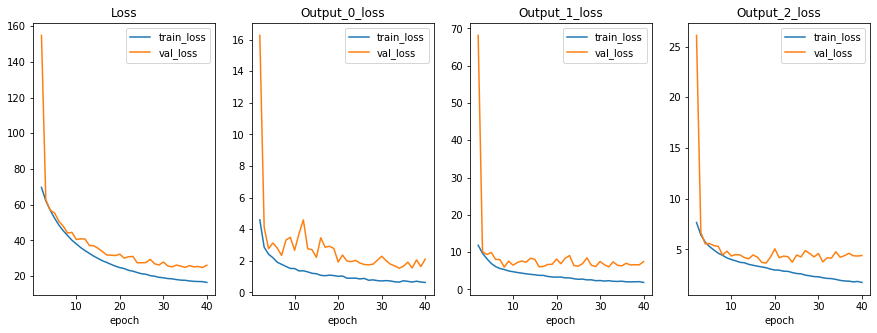

In [24]:
x = lossDf.Epoch
fig, ax = plt.subplots(nrows=1,ncols = 4,figsize=(15,5))
l1,l2 = ax[0].plot(x, lossDf[['loss','val_loss']])
_ = ax[0].set_xlabel('epoch')
_ = ax[0].set_title('Loss')
_ = ax[0].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[1].plot(x, lossDf[['yolo_output_0_loss','val_yolo_output_0_loss']])
_ = ax[1].set_xlabel('epoch')
_ = ax[1].set_title('Output_0_loss')
_ = ax[1].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[2].plot(x, lossDf[['yolo_output_1_loss','val_yolo_output_1_loss']])
_ = ax[2].set_xlabel('epoch')
_ = ax[2].set_title('Output_1_loss')
_ = ax[2].legend([l1,l2],['train_loss','val_loss'])
l1,l2 = ax[3].plot(x, lossDf[['yolo_output_2_loss','val_yolo_output_2_loss']])
_ = ax[3].set_xlabel('epoch')
_ = ax[3].set_title('Output_2_loss')
_ = ax[3].legend([l1,l2],['train_loss','val_loss'])